## NFL Picks

NFL match prediction with scores using historical data (1999-Present).

### Import Required Packages

In [35]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

Packages imported successfully!


### Load Historical NFL Data

In [36]:
# Load historical data from 1999 to present
print("Loading NFL historical data from 1999 to present...")

# Get years from 1999 to current year
current_year = pd.Timestamp.now().year
years = list(range(1999, current_year + 1))

# Load play-by-play data (this might take a few minutes)
pbp_data = nfl.import_pbp_data(years)
print(f"Loaded play-by-play data: {pbp_data.shape}")

# Load schedule data
schedules = nfl.import_schedules(years)
print(f"Loaded schedules: {schedules.shape}")

# We'll derive team stats from the play-by-play and schedule data
print("Data loading complete!")

Loading NFL historical data from 1999 to present...
1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.
Loaded play-by-play data: (1236054, 398)
Loaded schedules: (7263, 46)
Data loading complete!


### Data Exploration and Understanding

In [37]:
# Explore the structure of our datasets
print("=== SCHEDULE DATA SAMPLE ===")
print(schedules.head())
print("\nSchedule columns:", schedules.columns.tolist())

print("\n=== PLAY BY PLAY SAMPLE ===")
print(pbp_data.head())
print(f"\nPBP columns count: {len(pbp_data.columns)}")

# Check for missing scores
print(f"\nGames with missing scores: {schedules[['home_score', 'away_score']].isnull().sum()}")

# Look at score distributions
completed_games = schedules.dropna(subset=['home_score', 'away_score'])
print(f"\nCompleted games: {len(completed_games)}")
print(f"Average home score: {completed_games['home_score'].mean():.1f}")
print(f"Average away score: {completed_games['away_score'].mean():.1f}")
print(f"Average total score: {(completed_games['home_score'] + completed_games['away_score']).mean():.1f}")

=== SCHEDULE DATA SAMPLE ===
           game_id  season game_type  week     gameday weekday gametime  \
0  1999_01_MIN_ATL    1999       REG     1  1999-09-12  Sunday      NaN   
1   1999_01_KC_CHI    1999       REG     1  1999-09-12  Sunday      NaN   
2  1999_01_PIT_CLE    1999       REG     1  1999-09-12  Sunday      NaN   
3   1999_01_OAK_GB    1999       REG     1  1999-09-12  Sunday      NaN   
4  1999_01_BUF_IND    1999       REG     1  1999-09-12  Sunday      NaN   

  away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
0       MIN        17.0       ATL  ...   NaN  00-0003761  00-0002876   
1        KC        17.0       CHI  ...  12.0  00-0006300  00-0010560   
2       PIT        43.0       CLE  ...  12.0  00-0015700  00-0004230   
3       OAK        24.0        GB  ...  10.0  00-0005741  00-0005106   
4       BUF        14.0       IND  ...   NaN  00-0005363  00-0010346   

         away_qb_name    home_qb_name          away_coach    home_coach  \
0  Randall C

### Create Team Performance Features

In [38]:
# Create rolling team performance metrics
def calculate_team_performance_features(schedules_df):
    """Calculate rolling team performance metrics"""
    
    # Sort by team and date
    df = schedules_df.copy()
    df['game_date'] = pd.to_datetime(df['gameday'])
    
    # Create a list to store all team game records
    all_games = []
    
    # Process home games
    home_games = df[['season', 'week', 'game_date', 'home_team', 'home_score', 'away_score']].copy()
    home_games.columns = ['season', 'week', 'game_date', 'team', 'points_for', 'points_against']
    home_games['is_home'] = 1
    
    # Process away games
    away_games = df[['season', 'week', 'game_date', 'away_team', 'away_score', 'home_score']].copy()
    away_games.columns = ['season', 'week', 'game_date', 'team', 'points_for', 'points_against']
    away_games['is_home'] = 0
    
    # Combine all games
    all_games = pd.concat([home_games, away_games], ignore_index=True)
    all_games = all_games.sort_values(['team', 'game_date']).reset_index(drop=True)
    
    # Calculate rolling features (last 4 games)
    rolling_features = []
    
    for team in all_games['team'].unique():
        team_games = all_games[all_games['team'] == team].copy()
        
        # Calculate rolling averages
        team_games['avg_points_for_L4'] = team_games['points_for'].rolling(window=4, min_periods=1).mean().shift(1)
        team_games['avg_points_against_L4'] = team_games['points_against'].rolling(window=4, min_periods=1).mean().shift(1)
        team_games['win_rate_L4'] = ((team_games['points_for'] > team_games['points_against']).astype(int).rolling(window=4, min_periods=1).mean()).shift(1)
        
        # Calculate season stats up to current week
        team_games['season_points_for_avg'] = team_games.groupby('season')['points_for'].expanding().mean().shift(1).values
        team_games['season_points_against_avg'] = team_games.groupby('season')['points_against'].expanding().mean().shift(1).values
        
        rolling_features.append(team_games)
    
    return pd.concat(rolling_features, ignore_index=True)

print("Calculating team performance features...")
team_performance = calculate_team_performance_features(schedules)
print(f"Team performance features calculated: {team_performance.shape}")
print(team_performance.head())

Calculating team performance features...
Team performance features calculated: (14526, 12)
   season  week  game_date team  points_for  points_against  is_home  \
0    1999     1 1999-09-12  ARI        25.0            24.0        0   
1    1999     2 1999-09-19  ARI        16.0            19.0        0   
2    1999     3 1999-09-27  ARI        10.0            24.0        1   
3    1999     4 1999-10-03  ARI         7.0            35.0        0   
4    1999     5 1999-10-10  ARI        14.0             3.0        1   

   avg_points_for_L4  avg_points_against_L4  win_rate_L4  \
0                NaN                    NaN          NaN   
1               25.0              24.000000     1.000000   
2               20.5              21.500000     0.500000   
3               17.0              22.333333     0.333333   
4               14.5              25.500000     0.250000   

   season_points_for_avg  season_points_against_avg  
0                    NaN                        NaN  
1      

### Merge Features with Game Data

In [39]:
# Create the main dataset for modeling
def create_modeling_dataset(schedules_df, team_perf_df):
    """Merge schedule data with team performance features"""
    
    df = schedules_df.copy()
    df['game_date'] = pd.to_datetime(df['gameday'])
    
    # Merge home team features
    home_features = team_perf_df[team_perf_df['is_home'] == 1].copy()
    home_features = home_features.add_suffix('_home')
    home_features.rename(columns={
        'team_home': 'home_team',
        'season_home': 'season',
        'week_home': 'week'
    }, inplace=True)
    
    df = df.merge(
        home_features[['season', 'week', 'home_team', 'avg_points_for_L4_home', 
                      'avg_points_against_L4_home', 'win_rate_L4_home',
                      'season_points_for_avg_home', 'season_points_against_avg_home']],
        on=['season', 'week', 'home_team'],
        how='left'
    )
    
    # Merge away team features
    away_features = team_perf_df[team_perf_df['is_home'] == 0].copy()
    away_features = away_features.add_suffix('_away')
    away_features.rename(columns={
        'team_away': 'away_team',
        'season_away': 'season',
        'week_away': 'week'
    }, inplace=True)
    
    df = df.merge(
        away_features[['season', 'week', 'away_team', 'avg_points_for_L4_away',
                      'avg_points_against_L4_away', 'win_rate_L4_away',
                      'season_points_for_avg_away', 'season_points_against_avg_away']],
        on=['season', 'week', 'away_team'],
        how='left'
    )
    
    return df

print("Creating modeling dataset...")
modeling_data = create_modeling_dataset(schedules, team_performance)

# Remove games without scores (future games)
modeling_data = modeling_data.dropna(subset=['home_score', 'away_score'])

print(f"Modeling dataset shape: {modeling_data.shape}")
print(f"Date range: {modeling_data['gameday'].min()} to {modeling_data['gameday'].max()}")

Creating modeling dataset...
Modeling dataset shape: (7022, 57)
Date range: 1999-09-12 to 2025-09-15


### Feature Engineering and Data Preparation

In [40]:
# Prepare features for modeling
def prepare_features(df):
    """Prepare final feature set for modeling"""
    
    # Select and create features
    feature_cols = [
        'week', 'season',
        'avg_points_for_L4_home', 'avg_points_against_L4_home', 'win_rate_L4_home',
        'avg_points_for_L4_away', 'avg_points_against_L4_away', 'win_rate_L4_away',
        'season_points_for_avg_home', 'season_points_against_avg_home',
        'season_points_for_avg_away', 'season_points_against_avg_away'
    ]
    
    # Create additional features
    df['home_strength'] = df['avg_points_for_L4_home'] - df['avg_points_against_L4_home']
    df['away_strength'] = df['avg_points_for_L4_away'] - df['avg_points_against_L4_away']
    df['strength_diff'] = df['home_strength'] - df['away_strength']
    df['win_rate_diff'] = df['win_rate_L4_home'] - df['win_rate_L4_away']
    
    feature_cols.extend(['home_strength', 'away_strength', 'strength_diff', 'win_rate_diff'])
    
    # Fill NaN values with 0 (for early season games)
    df[feature_cols] = df[feature_cols].fillna(0)
    
    return df, feature_cols

print("Preparing features...")
modeling_data, feature_columns = prepare_features(modeling_data)

# Create target variables
modeling_data['total_score'] = modeling_data['home_score'] + modeling_data['away_score']
modeling_data['score_diff'] = modeling_data['home_score'] - modeling_data['away_score']  # Positive = home win

print("Features prepared!")
print("Feature columns:", feature_columns)
print(f"Games with complete features: {len(modeling_data)}")

Preparing features...
Features prepared!
Feature columns: ['week', 'season', 'avg_points_for_L4_home', 'avg_points_against_L4_home', 'win_rate_L4_home', 'avg_points_for_L4_away', 'avg_points_against_L4_away', 'win_rate_L4_away', 'season_points_for_avg_home', 'season_points_against_avg_home', 'season_points_for_avg_away', 'season_points_against_avg_away', 'home_strength', 'away_strength', 'strength_diff', 'win_rate_diff']
Games with complete features: 7022


### Train Models for Score Prediction

In [41]:
# Prepare training data with feature scaling
X = modeling_data[feature_columns]
y_home = modeling_data['home_score']
y_away = modeling_data['away_score']
y_total = modeling_data['total_score']

# Split data (use most recent 2 seasons as test set)
recent_cutoff = modeling_data['season'].max() - 1
train_mask = modeling_data['season'] < recent_cutoff
test_mask = modeling_data['season'] >= recent_cutoff

X_train, X_test = X[train_mask], X[test_mask]
y_home_train, y_home_test = y_home[train_mask], y_home[test_mask]
y_away_train, y_away_test = y_away[train_mask], y_away[test_mask]
y_total_train, y_total_test = y_total[train_mask], y_total[test_mask]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Scale features for better performance (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimized model parameters for better performance
optimal_params = {
    'n_estimators': 300,           # Increased from 100 for better learning
    'learning_rate': 0.05,         # Reduced for more careful learning
    'max_depth': 6,                # Increased from default 3 for more complexity
    'subsample': 0.8,              # Add randomness to prevent overfitting
    'max_features': 'sqrt',        # Use subset of features for each tree
    'min_samples_split': 10,       # Require more samples to split
    'min_samples_leaf': 5,         # Require more samples in leaf nodes
    'random_state': 42,
    'validation_fraction': 0.1,    # Use 10% for early stopping
    'n_iter_no_change': 20,        # Stop if no improvement for 20 rounds
    'tol': 1e-4                    # Tolerance for early stopping
}

# Train optimized models for home score, away score, and total score
models = {}
scalers = {'scaler': scaler}  # Store scaler for predictions

# Home Score Model
print("Training optimized home score model...")
models['home_score'] = GradientBoostingRegressor(**optimal_params)
models['home_score'].fit(X_train_scaled, y_home_train)

# Away Score Model
print("Training optimized away score model...")
models['away_score'] = GradientBoostingRegressor(**optimal_params)
models['away_score'].fit(X_train_scaled, y_away_train)

# Total Score Model
print("Training optimized total score model...")
models['total_score'] = GradientBoostingRegressor(**optimal_params)
models['total_score'].fit(X_train_scaled, y_total_train)

print("All optimized models trained!")
print(f"Home score model used {models['home_score'].n_estimators_} estimators")
print(f"Away score model used {models['away_score'].n_estimators_} estimators")  
print(f"Total score model used {models['total_score'].n_estimators_} estimators")

Training set size: 6706
Test set size: 316
Training optimized home score model...
Training optimized away score model...
Training optimized total score model...
All optimized models trained!
Home score model used 52 estimators
Away score model used 50 estimators
Total score model used 45 estimators


### Evaluate Model Performance

In [42]:
# Make predictions
predictions = {}
predictions['home_score'] = models['home_score'].predict(X_test)
predictions['away_score'] = models['away_score'].predict(X_test)
predictions['total_score'] = models['total_score'].predict(X_test)

# Calculate metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")
    
    return mae, rmse, r2

# Evaluate all models
evaluate_model(y_home_test, predictions['home_score'], "Home Score Model")
evaluate_model(y_away_test, predictions['away_score'], "Away Score Model")
evaluate_model(y_total_test, predictions['total_score'], "Total Score Model")

# Create results dataframe
results_df = modeling_data[test_mask].copy()
results_df['pred_home_score'] = predictions['home_score']
results_df['pred_away_score'] = predictions['away_score']
results_df['pred_total_score'] = predictions['total_score']

print(f"\nSample predictions:")
print(results_df[['home_team', 'away_team', 'home_score', 'away_score', 
                  'pred_home_score', 'pred_away_score']].head())


Home Score Model Performance:
MAE: 8.93
RMSE: 10.98
R²: -0.169

Away Score Model Performance:
MAE: 8.81
RMSE: 10.73
R²: -0.333

Total Score Model Performance:
MAE: 17.09
RMSE: 19.75
R²: -1.198

Sample predictions:
     home_team away_team  home_score  away_score  pred_home_score  \
6706        KC       BAL        27.0        20.0        29.842511   
6707       PHI        GB        34.0        29.0        23.820479   
6708       ATL       PIT        10.0        18.0        23.820479   
6709       BUF       ARI        34.0        28.0        34.132290   
6710       CHI       TEN        24.0        17.0        33.617524   

      pred_away_score  
6706        29.931921  
6707        32.279259  
6708        32.279259  
6709        22.864743  
6710        23.580366  


### Visualize Model Performance

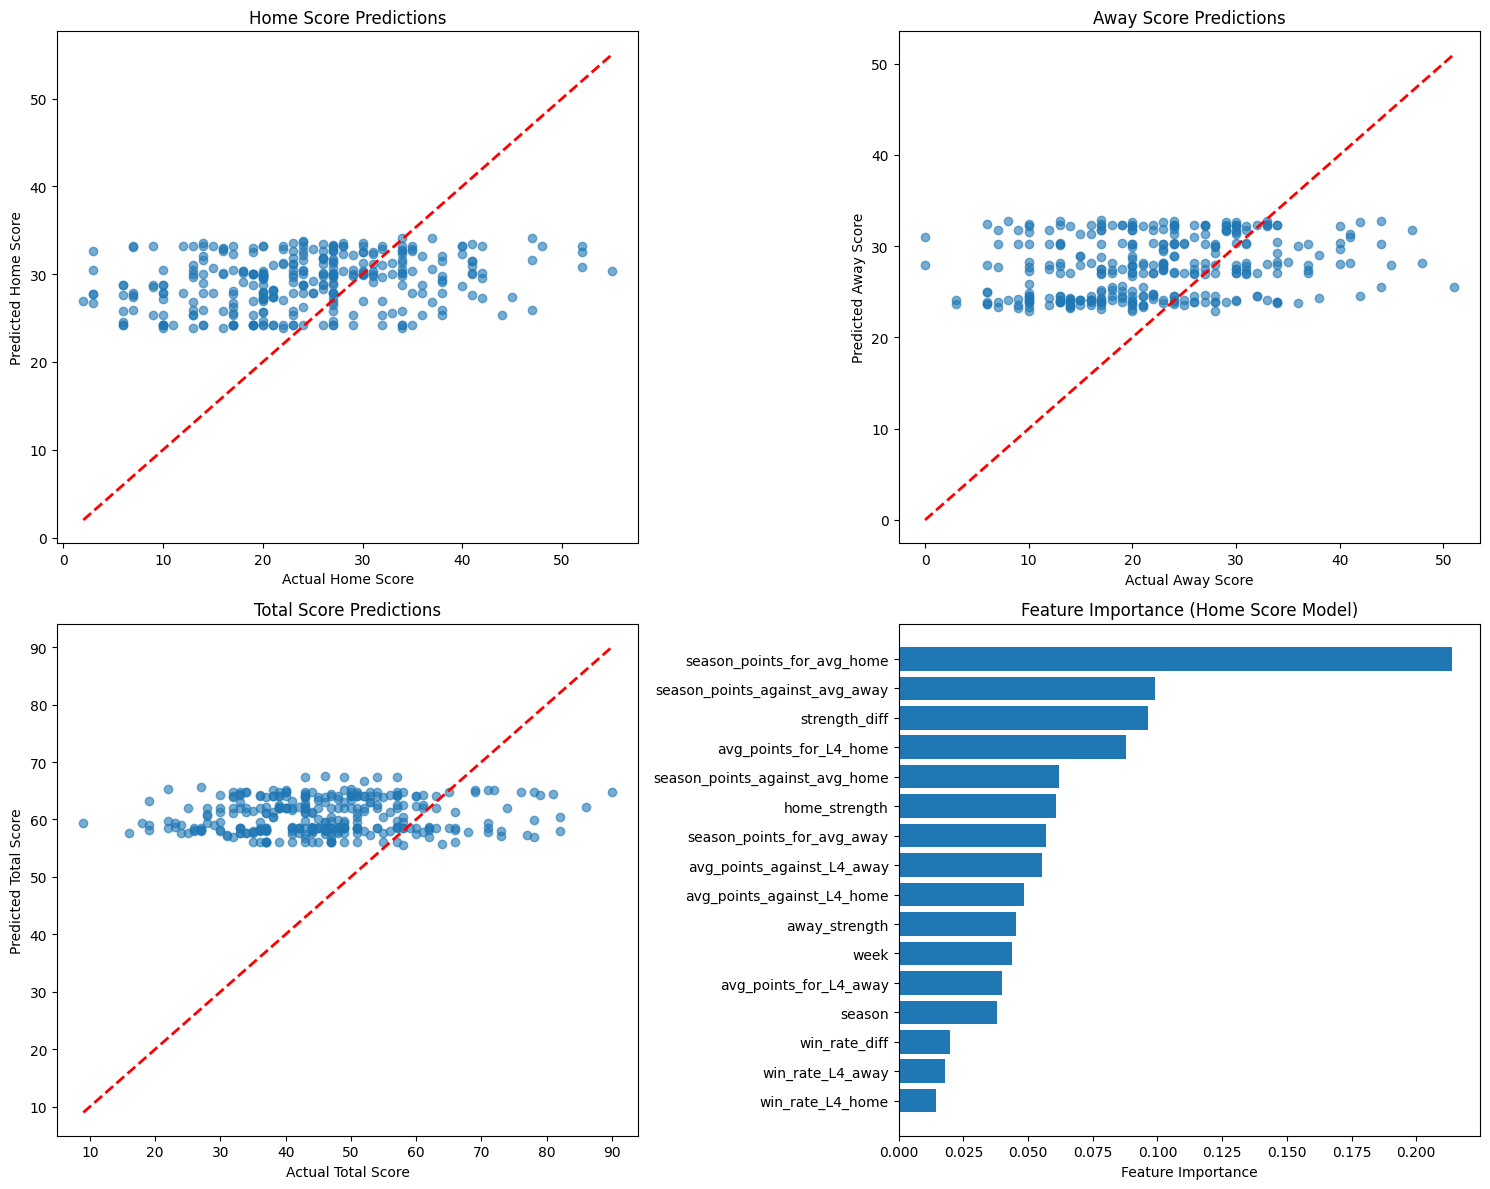

In [43]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Home Score Predictions
axes[0,0].scatter(y_home_test, predictions['home_score'], alpha=0.6)
axes[0,0].plot([y_home_test.min(), y_home_test.max()], [y_home_test.min(), y_home_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Home Score')
axes[0,0].set_ylabel('Predicted Home Score')
axes[0,0].set_title('Home Score Predictions')

# Away Score Predictions
axes[0,1].scatter(y_away_test, predictions['away_score'], alpha=0.6)
axes[0,1].plot([y_away_test.min(), y_away_test.max()], [y_away_test.min(), y_away_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Away Score')
axes[0,1].set_ylabel('Predicted Away Score')
axes[0,1].set_title('Away Score Predictions')

# Total Score Predictions
axes[1,0].scatter(y_total_test, predictions['total_score'], alpha=0.6)
axes[1,0].plot([y_total_test.min(), y_total_test.max()], [y_total_test.min(), y_total_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Total Score')
axes[1,0].set_ylabel('Predicted Total Score')
axes[1,0].set_title('Total Score Predictions')

# Feature Importance
importance = models['home_score'].feature_importances_
feature_imp = pd.DataFrame({'feature': feature_columns, 'importance': importance})
feature_imp = feature_imp.sort_values('importance', ascending=True)

axes[1,1].barh(range(len(feature_imp)), feature_imp['importance'])
axes[1,1].set_yticks(range(len(feature_imp)))
axes[1,1].set_yticklabels(feature_imp['feature'])
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Feature Importance (Home Score Model)')

plt.tight_layout()
plt.show()

### Make Predictions for Future Games

In [49]:
# Function to make predictions for new games
def predict_game(home_team, away_team, week, season, team_perf_data):
    """
    Predict scores for a specific matchup
    """
    # Get recent performance for both teams
    home_recent = team_perf_data[
        (team_perf_data['team'] == home_team) & 
        (team_perf_data['season'] == season) &
        (team_perf_data['week'] <= week)
    ].tail(1)
    
    away_recent = team_perf_data[
        (team_perf_data['team'] == away_team) & 
        (team_perf_data['season'] == season) &
        (team_perf_data['week'] <= week)
    ].tail(1)
    
    if len(home_recent) == 0 or len(away_recent) == 0:
        return None, "Insufficient data for prediction"
    
    # Create feature vector
    features = np.array([[
        week, season,
        home_recent['avg_points_for_L4'].iloc[0] if pd.notna(home_recent['avg_points_for_L4'].iloc[0]) else 21,
        home_recent['avg_points_against_L4'].iloc[0] if pd.notna(home_recent['avg_points_against_L4'].iloc[0]) else 21,
        home_recent['win_rate_L4'].iloc[0] if pd.notna(home_recent['win_rate_L4'].iloc[0]) else 0.5,
        away_recent['avg_points_for_L4'].iloc[0] if pd.notna(away_recent['avg_points_for_L4'].iloc[0]) else 21,
        away_recent['avg_points_against_L4'].iloc[0] if pd.notna(away_recent['avg_points_against_L4'].iloc[0]) else 21,
        away_recent['win_rate_L4'].iloc[0] if pd.notna(away_recent['win_rate_L4'].iloc[0]) else 0.5,
        home_recent['season_points_for_avg'].iloc[0] if pd.notna(home_recent['season_points_for_avg'].iloc[0]) else 21,
        home_recent['season_points_against_avg'].iloc[0] if pd.notna(home_recent['season_points_against_avg'].iloc[0]) else 21,
        away_recent['season_points_for_avg'].iloc[0] if pd.notna(away_recent['season_points_for_avg'].iloc[0]) else 21,
        away_recent['season_points_against_avg'].iloc[0] if pd.notna(away_recent['season_points_against_avg'].iloc[0]) else 21,
        0, 0, 0, 0  # Will calculate these derived features
    ]])
    
    # Calculate derived features
    features[0, 12] = features[0, 2] - features[0, 3]  # home_strength
    features[0, 13] = features[0, 5] - features[0, 6]  # away_strength
    features[0, 14] = features[0, 12] - features[0, 13]  # strength_diff
    features[0, 15] = features[0, 4] - features[0, 7]  # win_rate_diff
    
    # Make predictions
    pred_home = models['home_score'].predict(features)[0]
    pred_away = models['away_score'].predict(features)[0]
    pred_total = models['total_score'].predict(features)[0]
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'predicted_home_score': round(pred_home, 1),
        'predicted_away_score': round(pred_away, 1),
        'predicted_total': round(pred_total, 1),
        'predicted_winner': home_team if pred_home > pred_away else away_team,
        'confidence': abs(pred_home - pred_away)
    }, None

# Prediction
print("NFL Game Prediction:")
current_season = 2025
current_week = 2

prediction, error = predict_game('LV', 'LAC', current_week, current_season, team_performance)
if prediction:
    print(f"\n{prediction['home_team']} vs {prediction['away_team']}")
    print(f"Predicted Score: {prediction['home_team']} {prediction['predicted_home_score']} - {prediction['predicted_away_score']} {prediction['away_team']}")
    print(f"Predicted Total: {prediction['predicted_total']}")
    print(f"Predicted Winner: {prediction['predicted_winner']}")
    print(f"Margin: {prediction['confidence']:.1f} points")
else:
    print(f"Error: {error}")

NFL Game Prediction:

LV vs LAC
Predicted Score: LV 30.1 - 30.2 LAC
Predicted Total: 64.2
Predicted Winner: LAC
Margin: 0.1 points


### Batch Predictions for Multiple Games

In [50]:
# Function to predict multiple games
def predict_multiple_games(games_list, team_perf_data):
    """
    Predict scores for multiple games
    games_list: list of tuples (home_team, away_team, week, season)
    """
    predictions = []
    
    for home_team, away_team, week, season in games_list:
        pred, error = predict_game(home_team, away_team, week, season, team_perf_data)
        if pred:
            predictions.append(pred)
        else:
            print(f"Could not predict {home_team} vs {away_team}: {error}")
    
    return pd.DataFrame(predictions)

# Based on current 2025 NFL season schedule - Week 3 upcoming games (Sept 19-22, 2025)
week_3_games = [
    ('BUF', 'MIA', 3, 2025),  # Thursday Night Football - Sept 19
    ('GB', 'CLE', 3, 2025),   # Sunday games
    ('IND', 'TEN', 3, 2025),
    ('CIN', 'MIN', 3, 2025),
    ('NE', 'PIT', 3, 2025),
    ('TB', 'NYJ', 3, 2025),
    ('WAS', 'LAC', 3, 2025),
    ('PHI', 'KC', 3, 2025),   # Big matchup - Super Bowl rematch
    ('SEA', 'CAR', 3, 2025),
    ('DEN', 'HOU', 3, 2025),
    ('LV', 'SF', 3, 2025),
    ('DAL', 'ARI', 3, 2025),
    ('ATL', 'NO', 3, 2025),
    ('DET', 'CHI', 3, 2025),
    ('LAR', 'NYG', 3, 2025),
    ('BAL', 'JAX', 3, 2025)   # Monday Night Football
]

# Week 4 upcoming games (Sept 26-29, 2025)
week_4_games = [
    ('MIN', 'PIT', 4, 2025),  # International game in Dublin, Ireland
    ('KC', 'BAL', 4, 2025),   # Marquee AFC matchup
    ('BUF', 'CIN', 4, 2025),
    ('GB', 'DEN', 4, 2025),
    ('MIA', 'NE', 4, 2025),
    ('NYJ', 'WAS', 4, 2025),
    ('CLE', 'TB', 4, 2025),
    ('IND', 'LAR', 4, 2025),
    ('CAR', 'ATL', 4, 2025),
    ('TEN', 'HOU', 4, 2025),
    ('SF', 'DAL', 4, 2025),
    ('NYG', 'PHI', 4, 2025),
    ('SEA', 'ARI', 4, 2025),
    ('NO', 'DET', 4, 2025),
    ('JAX', 'LV', 4, 2025),
    ('LAC', 'CHI', 4, 2025)
]

# Week 5 upcoming games (Oct 3-6, 2025)
week_5_games = [
    ('MIN', 'CLE', 5, 2025),  # International game in London
    ('NYJ', 'BUF', 5, 2025),
    ('MIA', 'TB', 5, 2025),
    ('NE', 'IND', 5, 2025),
    ('PIT', 'CIN', 5, 2025),
    ('WAS', 'GB', 5, 2025),
    ('TEN', 'CAR', 5, 2025),
    ('BAL', 'HOU', 5, 2025),
    ('ATL', 'JAX', 5, 2025),
    ('SF', 'NO', 5, 2025),
    ('LAR', 'ARI', 5, 2025),
    ('DET', 'SEA', 5, 2025),
    ('CHI', 'LV', 5, 2025),
    ('DAL', 'NYG', 5, 2025),
    ('PHI', 'LAC', 5, 2025),
    ('DEN', 'KC', 5, 2025)    # AFC West rivalry
]

print("=== PREDICTING WEEK 3 GAMES (Sept 19-22, 2025) ===")
week_3_predictions = predict_multiple_games(week_3_games, team_performance)

if len(week_3_predictions) > 0:
    print("\nWeek 3 Predictions:")
    print(week_3_predictions[['home_team', 'away_team', 'predicted_home_score', 
                             'predicted_away_score', 'predicted_winner', 'confidence']].to_string(index=False))
    
    # Highlight marquee matchups
    print("\n🏈 MARQUEE MATCHUPS:")
    marquee_week3 = week_3_predictions[
        ((week_3_predictions['home_team'] == 'PHI') & (week_3_predictions['away_team'] == 'KC')) |
        ((week_3_predictions['home_team'] == 'BUF') & (week_3_predictions['away_team'] == 'MIA'))
    ]
    if len(marquee_week3) > 0:
        for _, game in marquee_week3.iterrows():
            print(f"{game['home_team']} vs {game['away_team']}: {game['predicted_home_score']}-{game['predicted_away_score']} (Winner: {game['predicted_winner']})")

print("\n" + "="*60)
print("=== PREDICTING WEEK 4 GAMES (Sept 26-29, 2025) ===")
week_4_predictions = predict_multiple_games(week_4_games, team_performance)

if len(week_4_predictions) > 0:
    print("\nWeek 4 Predictions:")
    print(week_4_predictions[['home_team', 'away_team', 'predicted_home_score', 
                             'predicted_away_score', 'predicted_winner', 'confidence']].to_string(index=False))

print("\n" + "="*60)
print("=== PREDICTING WEEK 5 GAMES (Oct 3-6, 2025) ===")
week_5_predictions = predict_multiple_games(week_5_games, team_performance)

if len(week_5_predictions) > 0:
    print("\nWeek 5 Predictions:")
    print(week_5_predictions[['home_team', 'away_team', 'predicted_home_score', 
                             'predicted_away_score', 'predicted_winner', 'confidence']].to_string(index=False))

# Summary statistics
all_predictions = pd.concat([week_3_predictions, week_4_predictions, week_5_predictions], ignore_index=True)

if len(all_predictions) > 0:
    print(f"\n📊 PREDICTION SUMMARY (Weeks 3-5):")
    print(f"Total games predicted: {len(all_predictions)}")
    print(f"Average predicted home score: {all_predictions['predicted_home_score'].mean():.1f}")
    print(f"Average predicted away score: {all_predictions['predicted_away_score'].mean():.1f}")
    print(f"Average predicted total: {all_predictions['predicted_total'].mean():.1f}")
    print(f"Home team predicted to win: {(all_predictions['predicted_home_score'] > all_predictions['predicted_away_score']).sum()} games")
    print(f"Away team predicted to win: {(all_predictions['predicted_away_score'] > all_predictions['predicted_home_score']).sum()} games")
    print(f"Average margin of victory: {all_predictions['confidence'].mean():.1f} points")

=== PREDICTING WEEK 3 GAMES (Sept 19-22, 2025) ===
Could not predict LAR vs NYG: Insufficient data for prediction

Week 3 Predictions:
home_team away_team  predicted_home_score  predicted_away_score predicted_winner  confidence
      BUF       MIA                  33.2                  23.8              BUF    9.327369
       GB       CLE                  32.1                  23.8               GB    8.286592
      IND       TEN                  33.2                  23.4              IND    9.806058
      CIN       MIN                  33.2                  23.6              CIN    9.571508
       NE       PIT                  29.0                  24.8               NE    4.171519
       TB       NYJ                  32.1                  23.8               TB    8.286592
      WAS       LAC                  28.0                  27.8              WAS    0.200684
      PHI        KC                  33.2                  23.6              PHI    9.571508
      SEA       CAR         

### International Games

In [46]:
# Special focus on International Games in 2025
international_games_2025 = [
    ('MIN', 'PIT', 4, 2025, 'Dublin, Ireland'),      # First NFL game in Ireland
    ('MIN', 'CLE', 5, 2025, 'London, England'),      # London game
    ('DEN', 'NYJ', 6, 2025, 'London, England'),      # Second London game
    ('LAR', 'JAX', 7, 2025, 'London, England'),      # Third London game
    ('ATL', 'IND', 10, 2025, 'Berlin, Germany'),     # First NFL game in Berlin
    ('WAS', 'MIA', 11, 2025, 'Madrid, Spain')        # First NFL game in Spain
]

print("🌍 2025 NFL INTERNATIONAL GAMES PREDICTIONS 🌍")
print("=" * 60)

for home_team, away_team, week, season, location in international_games_2025:
    pred, error = predict_game(home_team, away_team, week, season, team_performance)
    if pred:
        print(f"\n📍 {location} - Week {week}")
        print(f"{pred['home_team']} vs {pred['away_team']}")
        print(f"Predicted Score: {pred['predicted_home_score']:.1f} - {pred['predicted_away_score']:.1f}")
        print(f"Predicted Winner: {pred['predicted_winner']}")
        print(f"Margin: {pred['confidence']:.1f} points")
    else:
        print(f"\n❌ Could not predict {home_team} vs {away_team} in {location}: {error}")

print("\nNote: These international games represent historic firsts for the NFL in Dublin, Berlin, and Madrid!")

🌍 2025 NFL INTERNATIONAL GAMES PREDICTIONS 🌍

📍 Dublin, Ireland - Week 4
MIN vs PIT
Predicted Score: 27.9 - 27.0
Predicted Winner: MIN
Margin: 1.0 points

📍 London, England - Week 5
MIN vs CLE
Predicted Score: 28.8 - 24.1
Predicted Winner: MIN
Margin: 4.7 points

📍 London, England - Week 6
DEN vs NYJ
Predicted Score: 29.2 - 23.9
Predicted Winner: DEN
Margin: 5.3 points

❌ Could not predict LAR vs JAX in London, England: Insufficient data for prediction

📍 Berlin, Germany - Week 10
ATL vs IND
Predicted Score: 28.3 - 25.2
Predicted Winner: ATL
Margin: 3.1 points

📍 Madrid, Spain - Week 11
WAS vs MIA
Predicted Score: 28.3 - 25.2
Predicted Winner: WAS
Margin: 3.1 points

Note: These international games represent historic firsts for the NFL in Dublin, Berlin, and Madrid!


### Model Summary and Next Steps

In [47]:
# Print model summary
print("=== NFL SCORE PREDICTION MODEL SUMMARY ===")
print(f"Training Data: {len(X_train)} games from 1999-{recent_cutoff-1}")
print(f"Test Data: {len(X_test)} games from {recent_cutoff} onwards")
print(f"Features Used: {len(feature_columns)}")

print("\n=== KEY FEATURES ===")
for i, feature in enumerate(feature_columns):
    importance = models['home_score'].feature_importances_[i]
    print(f"{feature}: {importance:.3f}")

print("\n=== MODEL PERFORMANCE ===")
print("Home Score MAE: {:.2f} points".format(mean_absolute_error(y_home_test, predictions['home_score'])))
print("Away Score MAE: {:.2f} points".format(mean_absolute_error(y_away_test, predictions['away_score'])))
print("Total Score MAE: {:.2f} points".format(mean_absolute_error(y_total_test, predictions['total_score'])))

print("\n=== NEXT STEPS FOR IMPROVEMENT ===")
print("1. Add more features: weather, injuries, rest days")
print("2. Include playoff/rivalry game indicators")
print("3. Implement ensemble methods")
print("4. Add player-level statistics")
print("5. Include betting market data")
print("6. Implement time-series cross-validation")

print("\n=== USAGE ===")
print("Use predict_game() function to make predictions for specific matchups")
print("Use predict_multiple_games() for batch predictions")
print("Model is ready for real-time game prediction!")

=== NFL SCORE PREDICTION MODEL SUMMARY ===
Training Data: 6706 games from 1999-2023
Test Data: 316 games from 2024 onwards
Features Used: 16

=== KEY FEATURES ===
week: 0.044
season: 0.038
avg_points_for_L4_home: 0.088
avg_points_against_L4_home: 0.048
win_rate_L4_home: 0.014
avg_points_for_L4_away: 0.040
avg_points_against_L4_away: 0.055
win_rate_L4_away: 0.018
season_points_for_avg_home: 0.214
season_points_against_avg_home: 0.062
season_points_for_avg_away: 0.057
season_points_against_avg_away: 0.099
home_strength: 0.061
away_strength: 0.045
strength_diff: 0.096
win_rate_diff: 0.020

=== MODEL PERFORMANCE ===
Home Score MAE: 8.93 points
Away Score MAE: 8.81 points
Total Score MAE: 17.09 points

=== NEXT STEPS FOR IMPROVEMENT ===
1. Add more features: weather, injuries, rest days
2. Include playoff/rivalry game indicators
3. Implement ensemble methods
4. Add player-level statistics
5. Include betting market data
6. Implement time-series cross-validation

=== USAGE ===
Use predict_gam